# 4. Adjoint optimization

## Overview

In this tutorial, we will build a simple example application that showcases differentiation and optimization of a light transport simulation involving the well-known Cornell Box scene. We are going to optimize the color of one of the walls of the Cornell Box to match a target image.

Mitsuba’s ability to automatically differentiate entire rendering algorithms builds on differentiable JIT array types provided by the Enoki library. Those are explained in the [Enoki documentation](...). The linked document also discusses key differences compared to superficially similar frameworks like PyTorch and TensorFlow. For *automatic differentiation* (AD), Enoki records and simplifies computation graphs and uses them to propagate derivatives in forward or reverse mode. Before getting further into this tutorial, we recommend that you familiarize yourself this document.

<div class="alert alert-block alert-info">

✔️ **What will you learn?**
    
<ul>
  <li>Passing scene arguments when loading an XML file</li>
  <li>Build an optimization pipeline using the optimizer classes</li>
  <li>Perform gradient-based optimization using automatic differentiation</li>
</ul>
    
</div>


### Step 1 - setup

In order to use the automatic differentiation, we need to enable a variant that supports it. Those are the ones containing `_ad` after the backend description. E.g. `cuda_ad_rgb`, `llvm_ad_rgb`, ... 

In [1]:
# Add mitsuba and enoki to PATH (this shouldn't be necessary)
import sys
sys.path.append('../../../build/python')

In [2]:
from matplotlib import pyplot as plt

import enoki as ek 
import mitsuba
mitsuba.set_variant('llvm_ad_rgb')

It is possible to pass arguments directly to the scene via the `load_file` rountine.

In [3]:
from mitsuba.core.xml import load_file
from mitsuba.python.util import traverse, convert_to_bitmap

def show_image(img, title):
    plt.imshow(convert_to_bitmap(img)); plt.axis('off'); plt.title(title);

scene = load_file('../scenes/cbox.xml', res=128, spp=16, max_depth=3, integrator='rb')

2021-09-13 16:39:41 INFO main [xml.cpp:1261] Loading XML file "../scenes/cbox.xml" ..

2021-09-13 16:39:41 INFO main [xml.cpp:1262] Using variant "llvm_ad_rgb"

2021-09-13 16:39:41 INFO main [Scene] Embree ready. (took 19ms)

2021-09-13 16:39:41 INFO main [SamplingIntegrator] Start rendering...

2021-09-13 16:39:41 INFO main [SamplingIntegrator] Computation graph recorded. (took 17ms)

2021-09-13 16:39:41 INFO main [SamplingIntegrator] Code generation finished. (took 3ms)

2021-09-13 16:39:41 INFO main [SamplingIntegrator] Rendering finished. (took 35ms)

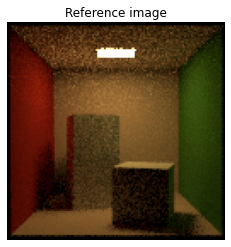

In [4]:
# ek.set_log_level(3)
integrator = scene.integrator()
image_ref = integrator.render(scene, seed=0)
show_image(image_ref, 'Reference image')

In [5]:
image_ref = integrator.render(scene, seed=0)
ek.eval(image_ref)

2021-09-13 16:39:41 INFO main [SamplingIntegrator] Start rendering...

2021-09-13 16:39:41 INFO main [SamplingIntegrator] Computation graph recorded. (took 25ms)

2021-09-13 16:39:41 INFO main [SamplingIntegrator] Code generation finished. (took 9ms)

2021-09-13 16:39:41 INFO main [SamplingIntegrator] Rendering finished. (took 61ms)

2021-09-13 16:39:41 INFO main [SamplingIntegrator] Start rendering...

2021-09-13 16:39:41 INFO main [SamplingIntegrator] Computation graph recorded. (took 14ms)

2021-09-13 16:39:41 INFO main [SamplingIntegrator] Code generation finished. (took 3ms)

2021-09-13 16:39:41 INFO main [SamplingIntegrator] Rendering finished. (took 77ms)

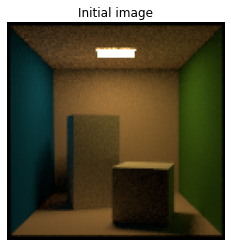

In [6]:
from mitsuba.core import Color3f, UInt32

# Update scene parameter
params = traverse(scene)
key = 'redwall.bsdf.reflectance.value'
params.keep([key])
param_ref = Color3f(params[key])
params[key] = Color3f(0.01, 0.2, 0.9)
params.update()

# Render initial image
image_init = integrator.render(scene, seed=0, spp=128)
show_image(image_init, 'Initial image')

In [7]:
from mitsuba.python.ad import Adam

opt = Adam(lr=0.05, params=params)
opt.load(key)
opt.update()

In [8]:
def compute_image_loss(img, obj_func):  
    ek.enable_grad(img)
    ob_val = obj_func(img)
    ek.backward(ob_val)
    image_loss = ek.grad(img)
    ek.set_grad(img, 0.0)
    return image_loss
    
def MSE(img):
    return ek.hsum_async(ek.sqr(img - image_ref)) / len(img)

from mitsuba.core import Thread, LogLevel
Thread.thread().logger().set_log_level(LogLevel.Error)

errors = []
for it in range(50):        
#     img = mitsuba.python.ad.render(scene)
#     loss = ...
#     ek.backward(loss)
    
    # Perform a differentiable rendering of the scene
    with ek.suspend_grad():
        image = integrator.render(scene, seed=0, spp=16)
    image_adj = compute_image_loss(image, MSE)
    integrator.render_backward(scene, opt, image_adj, seed=0, spp=16)

    # Optimizer: take a gradient step
    opt.step()
    
    opt[key] = ek.clamp(opt[key], 0.0, 1.0)
    
    # Optimizer: Update the scene parameters
    opt.update()
        
    err_ref = ek.hsum(ek.sqr(param_ref - params[key]))
    print('Iteration %03i: error=%g' % (it, err_ref[0]))
    errors.append(err_ref)

Iteration 000: error=0.920983
Iteration 001: error=0.786881
Iteration 002: error=0.667975
Iteration 003: error=0.563307
Iteration 004: error=0.469859
Iteration 005: error=0.385685
Iteration 006: error=0.311808
Iteration 007: error=0.247954
Iteration 008: error=0.193658
Iteration 009: error=0.148118
Iteration 010: error=0.110897
Iteration 011: error=0.0814496
Iteration 012: error=0.0590653
Iteration 013: error=0.042857
Iteration 014: error=0.031802
Iteration 015: error=0.0248236
Iteration 016: error=0.0208903
Iteration 017: error=0.0191027
Iteration 018: error=0.0187398
Iteration 019: error=0.019261
Iteration 020: error=0.0202754
Iteration 021: error=0.0212659
Iteration 022: error=0.0201753
Iteration 023: error=0.018537
Iteration 024: error=0.0164903
Iteration 025: error=0.0141733
Iteration 026: error=0.0117325
Iteration 027: error=0.00932507
Iteration 028: error=0.00710911
Iteration 029: error=0.00522294
Iteration 030: error=0.00376298
Iteration 031: error=0.00276843
Iteration 032: err

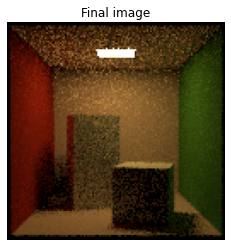

In [9]:
with opt.suspend_gradients():
    image_final = integrator.render(scene, seed=0, spp=8)
    show_image(image_final, 'Final image')

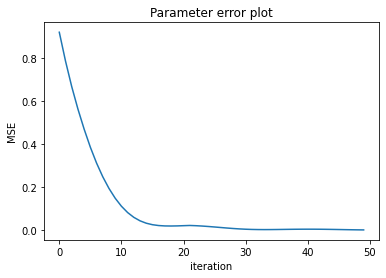

In [10]:
plt.plot(errors)
plt.xlabel('iteration'); plt.ylabel('MSE'); plt.title('Parameter error plot');

### *Reference API*

- [<code>mitsuba.core.xml.load_file</code>](https://mitsuba2.readthedocs.io/en/latest/generated/core_api.html#mitsuba.core.xml.load_file)